In [115]:
import base64
from IPython.display import display_svg
from urllib.request import Request, urlopen

def mm(graph):
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    url="https://mermaid.ink/svg/" + base64_string
    req=Request(url, headers={'User-Agent': 'IPython/Notebook'})
    display_svg(urlopen(req).read().decode(), raw=True)

# Data analysis techniques - individual project
# Carmel Gafa

## Some background - what we are talking about

​The `Arousal-Valence Model` is a visual framework that organizes emotions based on arousal (ranging from calm to agitated) and valence (ranging from negative to positive). By pinpointing one's position within this matrix, individuals can better understand their emotional states, enhancing both emotional and bodily awareness. This tool is particularly beneficial for neurodivergent individuals who may face challenges in identifying and regulating emotions, as it bridges the gap between physical sensations and emotional recognition. ​

Visual aids like the `Arousal-Valence Model` are instrumental in improving emotional intelligence, especially for those with neurodivergent traits such as ADHD or autism. These individuals often experience heightened levels of alexithymia, making it difficult to label and process emotions. By utilizing visual tools, they can more effectively recognize patterns in their emotional experiences and identify triggers that lead to specific responses. This approach not only aids in emotional identification but also supports the development of coping strategies, ultimately fostering better emotional regulation and well-being. ​


<div>
<img src="img/img-arousal-valence.png" width="500"/>
</div>
<sup><sup>Image taken from [1]</sup></sup>


### Mel frequency cepstral co-efficients

 One of the most widely used features in speech processing is the Mel Frequency Cepstral Coefficients (MFCCs).

MFCCs represent the short-term power spectrum of an audio signal and are designed to mimic how humans perceive sound. The key idea is to capture the spectral envelope of speech — essentially how the vocal tract is shaped during speech production — which plays a crucial role in conveying emotion. The MFCC extraction pipeline is as follows:

<div>
<img src="img/img-mfcc.webp" width="500"/>
</div>
<sup><sup>Image taken from [2]</sup></sup>

We can see that the pipeline consists of a number of stages:

- Framing & Windowing: The audio signal is split into short overlapping frames (e.g. 25 ms) to capture stationarity.
- Fast Fourier Transform: Converts each frame from the time domain to the frequency domain.
- Mel Filter Bank: Applies a set of filters spaced according to the Mel scale, which better reflects human auditory perception.
- Log Energy: Emphasizes low-energy components and simulates how humans perceive loudness.
- Discrete Cosine Transform: Used to decorrelate and compress the filterbank energies into a small number of coefficients — the MFCCs.

MFCC are important because they

- Capture the timbre and articulation of speech — features that are sensitive to emotional variation.
- They are particularly informative when a speaker is:
    - Speaking fast or loud (high arousal)
    - Speaking in a soft or relaxed tone (low arousal)
    - Using a positive or negative tone (affecting valence)

MFCCs do not explicitly model prosodic features such as:

- Pitch (F0)
- Intensity (energy)
- Speech rate or rhythm

These features can also be strong indicators of emotion, so MFCCs are sometimes combined with other features such as pitch and intensity.

The dataset includes 130 acoustic features extracted using the openSMILE toolkit, commonly used for speech analysis. These features capture multiple sound characteristics of the speech signal, such as tone, intensity, and rhythm. The 130 features include:

- MFCCs
    - Static coefficients: `mfcc_sma[1]` to `mfcc_sma[14]`
    - Dynamic (delta) coefficients: `mfcc_sma_de[1]` to `mfcc_sma_de[14]`
- Spectral descriptors
    - Includes spectral centroid, roll-off, entropy, variance, skewness, and slope — describing tone and sharpness.
- Prosodic features:
    - Includes pitch (F0), jitter, shimmer, and voicing probability — related to intonation and vocal stability.
- Energy-based features:
    - Includes RMS energy, log harmonic-to-noise ratio (logHNR), and zero-crossing rate — reflecting loudness and clarity.
- Filterbank energies:
    - `audSpec_Rfilt_sma[0–25]` and their delta derivatives — capturing frequency-band-specific energy profiles.
- Psychoacoustic measures:
    - Includes sharpness, harmonicity, and auditory spectrum length — modeling how humans perceive sound.

Each feature ends with `_amean`, indicating it is the mean value computed over a 3-second analysis window, after being extracted frame-by-frame (~25 ms windows with 10 ms hop).

---

**Sources**
 1. https://neurodivergentinsights.com/arousal-valence-model/
 2. https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd
 3. https://stackoverflow.com/questions/13810873/mfcc-13-coefficients
 4. https://opus.bibliothek.uni-augsburg.de/opus4/frontdoor/deliver/index/docId/77173/file/77173.pdf


In [116]:
# imports

import pandas as pd
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

## Preamble - Loading the data and initial inspection to get acquainted with the data

The data is uploaded and inspected in this stage. The following steps are carried out:

- The data is loaded into a pandas dataframe
- A summary of the data is created and saved in a file. It contains:
    - Feature name
    - Non-null count . It was noted that **all records** contained 7238 non-null values
    - Data type. It was noted that the `participant` feature is an integer, while all other features are floats. The response variables are also floats.
- An additional summary is created that shows the 10 features with the highest number of non-null values was carried out. This served as a second check that the dataset did not contain any missing records

### An initial look at the target values

- We start by examining the distributions of the two response variables, `median_arousal` and `median_valence`. We note that the distribution of `median_arousal` is skewed to the left, while the distribution of `median_valence` is skewed to the right.
- We examine the descriptive statistics of the two response variables. We note that for 
    - `median_arousal` 
        - the mean is 0.010609
        - the skewness is -0.424667, indicating that the distribution is skewed to the left
        - the kurtosis is  -0.260799, indicating that the distribution is slightly platykurtic, that is, it is flatter than a normal distribution
    - `median_valence`
        - the mean is 0.083961.
        - the skewness is 0.698025, indicating that the distribution is skewed to the right
        - the kurtosis is 0.192967, indicating that the distribution is slightly leptokurtic, that is, it is more peaked than a normal distribution
- We finally plot `median_arousal` vs `median_valence` scatter plot to identify the relationship between the two predictors. 
    - The data shows a somewhat positive trend between the predictors although possibly not linear. 


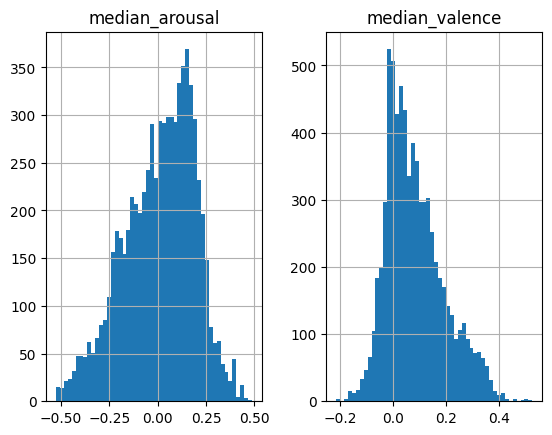

desccriptive statistics of arousal and valence:
-----------------------------------------------
       median_arousal  median_valence
count     7238.000000     7238.000000
mean         0.010609        0.083961
std          0.182776        0.109831
min         -0.526533       -0.214067
25%         -0.115183        0.001067
50%          0.034000        0.063900
75%          0.149317        0.147383
max          0.487000        0.526133
skewness of arousal and valence:
--------------------------------
median_arousal   -0.424667
median_valence    0.698025
dtype: float64
kurtosis of arousal and valence:
--------------------------------
median_arousal   -0.260799
median_valence    0.192967
dtype: float64


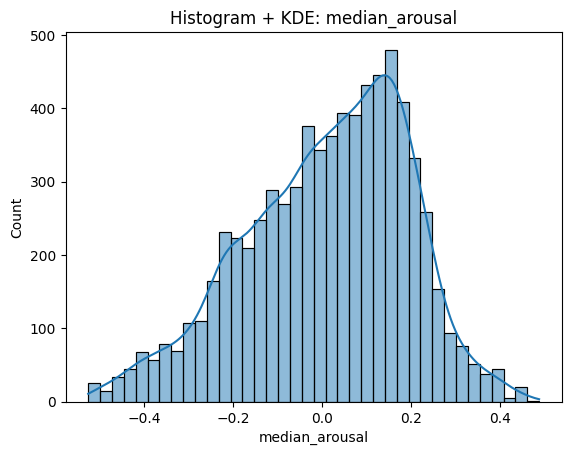

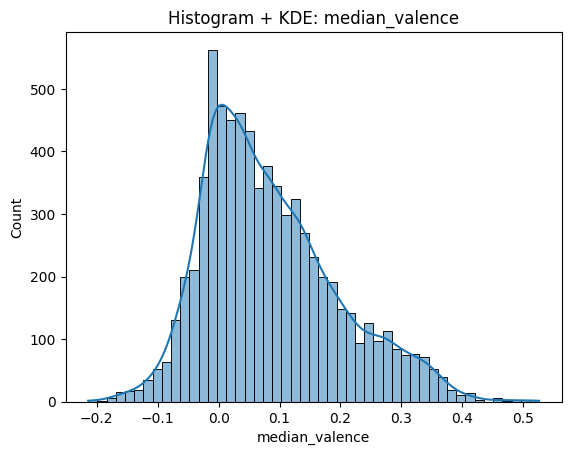

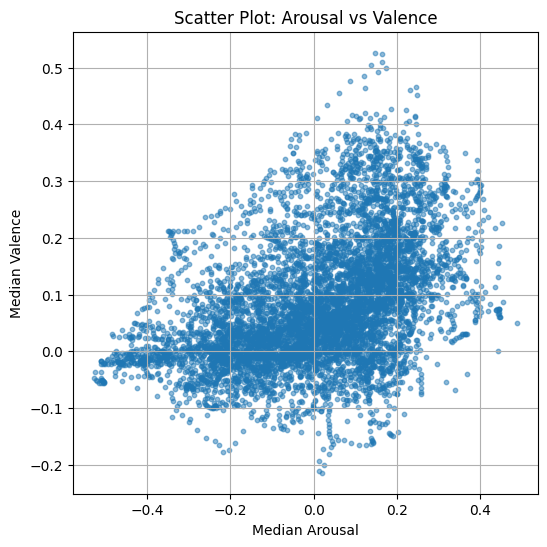

In [117]:
data_folder = 'data/'
data_filename = 'project_data.csv'

data_path = os.path.join(data_folder, data_filename)
df_raw = pd.read_csv(data_path, sep=',', header=0, encoding='utf-8')

# print(df_raw.head())


df_summary = pd.DataFrame({
    'Feature': df_raw.columns,
    'Non-Null Count': df_raw.notnull().sum().values,
    'Data Type': df_raw.dtypes.values
})

# just to be certain about non nulls
df_raw.isnull().sum().sort_values(ascending=False).head(10)


### An initial look at the target values
### ------------------------------------

df_raw[['median_arousal', 'median_valence']].hist(bins=50)
plt.show()

print('desccriptive statistics of arousal and valence:')
print('-----------------------------------------------')
print(df_raw[['median_arousal', 'median_valence']].describe())
print('skewness of arousal and valence:')
print('--------------------------------')
print(df_raw[['median_arousal', 'median_valence']].skew())
print('kurtosis of arousal and valence:')
print('--------------------------------')
print(df_raw[['median_arousal', 'median_valence']].kurt())


### Histograms of predictors

for col in ['median_arousal', 'median_valence']:
    sns.histplot(df_raw[col], kde=True)
    plt.title(f"Histogram + KDE: {col}")
    plt.show()

### relationships between predictors


plt.figure(figsize=(6, 6))
plt.scatter(df_raw['median_arousal'], df_raw['median_valence'], alpha=0.5, s=10)
plt.xlabel('Median Arousal')
plt.ylabel('Median Valence')
plt.title('Scatter Plot: Arousal vs Valence')
plt.grid(True)
plt.show()



<div class="alert alert-block alert-info">

## Task 1
**If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:**

### Which performance metrics would you use to evaluate your model’s predictions?
</div>

As the labels in this exercise, `median_arousal` and `median_valence` are present and are continuous variables, we are dealing with a supervised regression task.

In these cases, the cost function, which aggregates the individual loss functions across the dataset, can be used as it provides a single scalar value representing the model's overall performance on all training samples. It can be calculated as

$$
\frac{1}{m}\sum_{i=1}^{m} \mathcal{L}(\widehat{y}, y)
$$

There are many different cost functions, but in this exercise, the Mean Square Error will be used;
$$
MSE = \frac{\sum_{i=1}^{n} ( \hat{y}^{(i)}-y^{(i)} )^{2} }{n}
$$

Mean square error (MSE) diminishes the effect of negligible residuals and amplifies the larger residuals. MSE is, however, sensitive to outliers, so for this reason, the outliers' situation is first very briefly evaluated using the following code that ranks the number of outliers per feature:

In [118]:
from scipy.stats import zscore
z_scores = df_raw.drop(columns=['Participant', 'median_arousal', 'median_valence']).apply(zscore)
outlier_counts = (z_scores.abs() > 3).sum().sort_values(ascending=False)
print(outlier_counts)

ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[25]_amean         198
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[24]_amean         194
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[22]_amean         189
ComParE13_LLD_25Hz_audSpec_Rfilt_sma_de[23]_amean         186
ComParE13_LLD_25Hz_pcm_Mag_spectralSlope_sma_de_amean     184
                                                         ... 
ComParE13_LLD_25Hz_mfcc_sma[12]_amean                      20
ComParE13_LLD_25Hz_mfcc_sma[14]_amean                      20
ComParE13_LLD_25Hz_mfcc_sma_de[1]_amean                    19
ComParE13_LLD_25Hz_audspecRasta_lengthL1norm_sma_amean     17
ComParE13_LLD_25Hz_mfcc_sma[2]_amean                       10
Length: 130, dtype: int64



As the proportion of outliers is modest, it is acceptable to proceed with MSE as a primary performance metric. However there are additional nuisances related to outliers, such as the skewness of the distributions of the features. This factor is not considered at this stage, but, if MAE will give inconsistent results because of the outliers an alternative metric like Mean Absolute Error will be used. 

$$MAE = \frac{\sum_{i=1}^{n} | \hat{y}_i-y_i | }{n}$$

Mean absolute error is often used where the data being considered contains outliers as it is less sensitive to large deviations when compared to other cost functions like the mean square error.

An additional metric that will be used in this case is the Coefficient of Determination ($R^2$) that measures the proportion of variance in $y$ explained by the model. This metric ranges from $-\infty$ to 1.

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

- $R^2 = 1$: perfect fit
- $R^2 = 0$: model does no better than mean
- $R^2 < 0$: model is worse than constant predictor

We can apply a system of threshold values to change the system to a classification one, with the simplest case involving a single threshold that will split the label into a high or low, true or false, etc., where such a system is referred to as a binary classifier. In this case, a different system of performance metrics is considered, where the fundamental consideration is the confusion matrix, a grid that identifies the elements that are correctly and incorrectly classified:

| **Prediction** | **Label Value** | **Outcome**         | **Description**                                                       |
| -------------- | --------------- | ------------------- | --------------------------------------------------------------------- |
| 1              | 1               | True Positive (TP)  | The model correctly predicted the positive class.                     |
| 1              | 0               | False Positive (FP) | The model incorrectly predicted the positive class (a "false alarm"). |
| 0              | 1               | False Negative (FN) | The model incorrectly predicted the negative class (a "miss").        |
| 0              | 0               | True Negative (TN)  | The model correctly predicted the negative class.                     |

The image below illustrates a typical confusion matrix and the metrics that emerge from it.

![Confusion Matrix](./img/img-confusion-matrix-1.jpg)

The performance metrics that will be used in this scenario include:

**Precision** is a robust metric used in cases where false positives are a concern, particularly in imbalanced datasets. It focuses on the proportion of True Positives (TP) out of all the samples that were predicted as positive (i.e., both True Positives and False Positives).

$$Precision=\frac{TP}{TP+FP}$$

Precision answers the question: "Out of all the observations predicted to be positive, how many were really positive?" In other words, it measures the model's ability to avoid false positives.

**Recall** focuses on the positive class and measures how well the model captures all positive instances, regardless of how many false positives it makes. It is imperative when missing positive cases (false negatives) is costly, such as in medical diagnoses (e.g., cancer detection) or fraud detection.

$$Recall=\frac{TP}{TP + FN}$$

Recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify as positive?"


**The F1-score** is the harmonic mean of precision and recall. It provides a single metric that balances precision and recall, which is useful when there is an uneven class distribution or when false positives and false negatives are essential.

The formula for the F1 score is:

<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-chtml.js"></script>


\begin{align}
F1 &= 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\\\\
&= 2\times \frac{TP}{2TP+FN+FP}
\end{align}


<div class="alert alert-block alert-info">

### Does the selection of the performance metric depend on the type of the response variables? Explain your reasoning.

</div>

This topic was addressed in the previous question, but to summarize, yes, the type of response variable does affect the performance metric.

If the response variable is continuous, such as arousal or valence in their original form, the problem is a regression task. In this case, appropriate performance metrics include:

- Mean Squared Error (MSE): $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$ penalizes larger errors more heavily and is useful for optimization.
- Mean Absolute Error (MAE): $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |\hat{y}_i - y_i$ is less sensitive to outliers and is easier to interpret.
- Coefficient of Determination ($R^2$ Score): $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$ evaluates how well the model explains the variance in the data.

If the response variable is categorical, such as after binarization ("high" vs "low") or discretization ("low", "neutral", "high"), the problem becomes a classification task. In that case, regression metrics are not appropriate, and instead classification metrics are used, typically derived from the confusion matrix:
- Accuracy: the proportion of correct predictions.
- Precision and Recall: especially important in imbalanced datasets.
- F1 Score: harmonic mean of precision and recall.
- ROC-AUC: useful for evaluating the ranking ability of probabilistic classifiers.
- Therefore, the selection of the performance metric must always align with the type of the response variable, as using an incorrect metric can lead to misleading evaluation of model performance.

<div class="alert alert-block alert-info">


### Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you use given that the objective is to build a predictive model able to generalise across participants (i.e., make accurate predictions for unseen participants)? Justify your choice.

</div>

Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you use given that the objective is to build a predictive model able to generalise across participants (i.e., make accurate predictions for unseen participants)? Justify your choice.

The challenge in this example's validation protocol selection is that the model has to generalise to unseen participants. The validation protocol must, therefore, prevent any overlap between the data used for training and the data used for evaluation across different participants that will lead to information leakage and overly optimistic performance estimates.

These considerations limit the use of popular validation techniques:

- **Holdout Set**. A simple train/test split may randomly divide samples from the same participant across both sets, resulting in data leakage, where the model indirectly "sees" the test distribution during training, leading to over-optimistic performance estimates. It also suffers from high variance, especially with a low participant count.
- **Standard K-Fold Cross-Validation** involves randomly partitioning data into $k$ folds without considering participant boundaries. Consequently, it may include data from the same participant in both training and testing folds, violating the independence assumption.
- **Stratified K-Fold** preserves label distribution across folds; however, it does not maintain group integrity. Samples from the same participant may appear in multiple folds, which can lead to data leakage and inaccurate metrics.

Following these considerations, **Group K-Fold Cross-Validation** can be used. Group K-Fold Cross-Validation is a data splitting strategy that ensures all samples from a given group appear entirely in either the training set or the validation set and **never in both**, preserving the independence between training and test data when samples are, **not i.i.d.**, but grouped.

Group K-Fold Cross-Validation is used because in grouped data, **generalisation to unseen groups** (not just unseen samples) is the real objective. Group K-Fold simulates this deployment scenario more faithfully than standard techniques.



<div class="alert alert-block alert-info">

## Task 2: Using the provided audio features, build predictive models for arousal and valence:
### Develop a predictive model for each response variable (arousal and valence) using some or all of the provided audio features as explanatory variables.
### Evaluate the implemented models using the metrics and validation protocol you proposed in Task 1.
### Interpret the trained models (if the selected approach allows for interpretation) and the obtained results.

</div>

## Task 2 Narrative

The initial architecture for this task utilized a scikit-learn pipeline structure, which was later discarded to allow for finer control and investigation of fold-level inconsistencies at all stages of the pipeline.

### Experiment 1 - Linear Regression

#### Input
- **Target Variable (`y_median_arousal`)**: the `median_arousal` column from the dataset.
- **Feature Matrix (`X`)**: all 130 acoustic features extracted from audio signals, excluding `Participant`, `median_arousal`, and `median_valence`.

#### Pipeline Components
- **GroupKFold**: with 10 splits was used to perform cross-validation using participants, so to ensure that each fold excluded one participant.
- **Recursive Feature Elimination**: applied to the training set of each fold using a `LinearRegression` estimator to select the top 10 features based on model coefficients.
- **StandardScaler**: applied after feature selection to standardize features to zero mean and unit variance, based solely on the training set.
- **LinearRegression**: trained on the selected and scaled features to model arousal as a continuous output.

#### Execution
Cross-validation was implemented manually in a loop using `GroupKFold`. For each fold:
- Features were selected using the training data.
- Selected features were scaled.
- The model was trained on the training set and evaluated on the held-out validation set.

#### Evaluation Metrics
Model performance was assessed using $R^2$, MSE and MAE that were computed for both training and validation sets to evaluate model fit and generalization.

Following the execution of this pipeline, a scatter plot was generated showing training versus validation $R^2$ values across folds.

![Linear regression results](./img/img-2-linear-regression.png)

The plot shows that the system suffered from both high bias and high variance. The low training $R^2$ values (between 0.23 and 0.28) indicated that the model was unable to fit the training data well, indicating underfitting and high bias. 

Simultaneously, validation performance was highly variable across folds, with some validation $R^2$ scores dropping below 0 and one fold reaching as low as –5.5. This extreme variability points to high variance.

Due to the issues with underfitting and instability, it was clear that we needed a better model. We chose the Random Forest Regressor because it can capture complex patterns and nonlinear interactions that linear regression can't, thus helping reduce bias in our predictions.

As the Random Forest Regressor performs ensemble averaging across multiple decision trees to produce stable predictions, it should also reduce variance.

### Experiment 2 - Random Forest Regressor and additional measures

The pipeline was subsequently modified by replacing the linear regressor with a Random Forest Regressor while leaving all other components (feature selection, scaling, and cross-validation setup) unchanged. This model modification was carried out to address the underfitting and limited expressiveness observed in the linear model. 
Under these conditions, the following scatter plot shows the comparison of training versus validation $R^2$ values across folds:

![Random Forest results](./img/img-2-random-forest-1.png)

The resulting scatter plot of training versus validation $R^2$ values indicates that the bias problem observed in the linear regression model has been effectively addressed as we started seeing consistently high training $R^2$ values across folds (0.916 to 0.925). The Random Forest Regressor is capable of capturing the underlying relationships in the training data.

However, the plot also reveals that the model exhibits considerable variance across validation folds, with validation $R^2$ values ranging from slightly negative up to approximately 0.1. One fold, in particular, shows a strongly negative validation $R^2$, suggesting that the specific model generalises poorly.

While this variability may initially seem concerning, it is not unexpected in the context of Group K-Fold cross-validation, where each validation fold corresponds to an entirely unseen participant, so it is acceptable for validation $R^2$ values to approach zero or even slightly dip below, especially when the data distribution diverges significantly from the training population.

Thus, while the high training performance confirms that Random Forests solve the underfitting issue (high bias), the persistent fold-to-fold variation reflects a high variance regime.


## Addressing poor performance

At this stage, a decent model had been developed that addressed most scenarios. However, before reaching complete satisfaction with the model, a solution was needed for the problematic fold, and there was also potential to improve the overall performance of the model.

A couple of techniques were implemented at this stage without objective analysis, an approach which proved to be very inefficient indeed. The underlying assumption at this stage was that the data contained outliers that were causing problems.

Replaced StandardScaler with RobustScaler to reduce sensitivity to outlier-prone features. There was a slight improvement in fold consistency, but core issues persisted. StandardScalar was then reintroduced.
Added two new principal components from PCA on the full feature matrix to the feature set before training to inject global structure and reduce unexplained variance. These features were removed as although there was a visual improvement in variance reduction in some folds, validation $R^2$ was slightly more stable but not universally improved.
Removed rows where `y_median_arousal` exceeded $|z| 3$, computed per participant to reduce label noise. This step did not substantially improve fold consistency but was retained for completeness' sake.

At this stage, it became clear that randomly searching for a good solution was not effective. It was essential to understand the cause of the validation $R^2$ results, particularly the one that produced a significantly poor outcome.

This investigation began with a slight modification to the scatter plot to understand which fold resulted in poor outcomes. As can be seen in the following plot, this was fold number 2.

![Analysis scatter](./img/img-2-analysis-scatter.png)

A thorough understanding of each iteration of the Group K-Fold execution was achieved to identify which participants were held out for validation. In particular, it was essential to determine the held-out participant in Fold-2. This analysis showed that the participant in question was number 6.

![Analysis scatter](./img/img-2-analysis-folds.png)

A box plot of `y_median_arousal` for every participant was created. The plot revealed numerous outliers in Participant 6, which initially raised questions about outlier elimination, as it had been previously carried out in the pipeline. Upon analysis of Participant 6, it was noticed that its distribution differed from the distribution of the other participants:

![Analysis scatter](./img/img-2-analysis-box.png)

- The mean was around 0.2, whereas the distribution of the other participants was around 0
- The distribution was very tight around the mean, whereas the distribution of the other participants was wider

It was, therefore, evident at this stage that the problem with Participant 6 was not due to outliers, albeit the box plot was portraying it as such. However, participant 6 is statistically different from all the others, and therefore, the model's assumptions do not apply to it, leading to a high validation error.

A good technique, given this information, is to normalise the target values of each participant as follows:
$$
text{normalized arousal}=\frac{ y−\mu_{participant​}}{ \sigma_{participant​}}
$$
Participant-level normalisation will mean that for all participants, the mean of mean_arousal will be zero, and its standard deviation will be 1. The model is, in this way, trained on the relative changes of mean_arousla and not the absolute values. This approach significantly improved the result, as evident in the final code pipeline below.

## Final pipeline

The final pipeline is as follows:

#### Input
- **Target Variable (`y_median_arousal`)**: Normalized per participant using z-score transformation:

  $$
  \text{normalized arousal} = \frac{y - \mu_{\text{participant}}}{\sigma_{\text{participant}}}
  $$

  This ensured that the model learned participant-relative changes in arousal rather than relying on absolute values.

- **Feature Matrix (`X`)**: All 130 acoustic features extracted from the dataset, excluding `Participant`, `median_arousal`, and `median_valence`.

#### Preprocessing Steps
- **Z-score Based Outlier Filtering**: For each participant, samples with absolute z-score of `median_arousal` exceeding 3 were removed to reduce label noise.
- **GroupKFold (n_splits=10)**: Used for participant-wise cross-validation, ensuring that each fold held out exactly one participant to simulate prediction on unseen individuals.

#### Pipeline Components
- **Recursive Feature Elimination (RFE)**: Applied to the training fold using a `LinearRegression` estimator to select the top 10 most informative features.
- **StandardScaler**: Applied only to the selected features of the training data and used to transform both training and validation subsets.
- **RandomForestRegressor**: Replaced the earlier linear model to address underfitting and model nonlinear relationships between features and normalized arousal values.

#### Execution
- Manual loop-based cross-validation was implemented using `GroupKFold`.
- In each fold:
  - Outlier filtering and normalization were preserved.
  - Features were selected using RFE.
  - Selected features were scaled using statistics from the training set.
  - A `RandomForestRegressor` was trained and evaluated.
- All transformations respected fold boundaries to prevent data leakage.

#### Evaluation Metrics
- **$R^2$ (Coefficient of Determination)**
- **Mean Squared Error (MSE)**
- **Mean Absolute Error (MAE)**

Each metric was calculated separately for both the training and validation sets, enabling fold-wise analysis of bias, variance, and generalization.


---

### Additional references 

- https://www.youtube.com/watch?v=6dDet0-Drzc


In [ ]:
# # draw boxplot of median_arousal for each participant
# df_raw.boxplot(column='median_arousal', by='Participant')
# plt.title('Boxplot of Median Arousal by Participant')
# plt.suptitle('')
# plt.show()


# for fold in range(NUMBER_OF_SPLITS):
#     selected_groups = results_df.loc[fold, 'Groups']
#     for group in groups_selected_df.index:
#         if group in selected_groups:
#             groups_selected_df.at[group, fold + 1] = 'yes'
#         else:
#             groups_selected_df.at[group, fold + 1] = 'no'

# groups_selected_df.to_csv("groups_selected.csv")

# # draw groups_selected_df as a heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(groups_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)
# plt.title('Groups Selected in Each Fold')
# plt.xlabel('Fold')
# plt.ylabel('Group')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore


# Outlier handling
# ----------------
cleaned_rows = []
z_thresh = 3

for pid in df_raw['Participant'].unique():
    participant_df = df_raw[df_raw['Participant'] == pid].copy()
    
    # Calculate Z-scores
    participant_df['z_arousal'] = zscore(participant_df['median_arousal'])
    
    # REMOVe
    participant_df = participant_df[participant_df['z_arousal'].abs() <= z_thresh]
    
    cleaned_rows.append(participant_df.drop(columns='z_arousal'))

df_clean = pd.concat(cleaned_rows, ignore_index=True)

print(f"Original dataset shape: {df_raw.shape}")
print(df_clean.shape)

# Start with the cleaned dataset
# ------------------------------

NUMBER_OF_SPLITS = 10
NUMBER_OF_RFE_FEATURES = 10

# Target variable preparation
# normalize the target variable median_arousal
# -----------------------------------------

y_median_arousal = df_clean.groupby('Participant')['median_arousal'].transform(
    lambda x: (x - x.mean()) / x.std()
)
print(f'Shape of target variable median_arousal: {y_median_arousal.shape}')

y_median_valence = df_clean.groupby('Participant')['median_valence'].transform(
    lambda x: (x - x.mean()) / x.std()
)
print(f'Shape of target variable median_valence: {y_median_valence.shape}')


groups = df_clean['Participant']
print(f'Number of unique participants: {len(groups.unique())}')

X = df_clean.drop(columns=['Participant', 'median_arousal', 'median_valence'])
print(f'Shape of feature matrix X: {X.shape}')


#given that we have 10 participants, we can use GroupKFold with 10 splits, so i can visualize bit better
gkf = GroupKFold(n_splits=NUMBER_OF_SPLITS)

# df to store results
results_df = pd.DataFrame(columns=['Fold', 'Groups', 'Selected Features', 'Train R^2', 'Train MSE', 'Train MAE', 'Val R^2', 'Val MSE', 'Val MAE'])

# Group K Fold Cross Validation
# -----------------------------

print('Group K Fold Start...')

fold_counter = 1
selected_features_folds = []

for train_index_fold, val_index_fold in gkf.split(X, y_median_arousal, groups):
    print(f'Fold {fold_counter} of {NUMBER_OF_SPLITS}')

    # print(f' groups in this fold: {groups[train_index_fold].unique()}')

    # split each fold into train and validation sets
    # ------------------------------------------------
    X_train, X_val = X.iloc[train_index_fold], X.iloc[val_index_fold]
    y_train, y_val = y_median_arousal.iloc[train_index_fold], y_median_arousal.iloc[val_index_fold]
    groups_train, groups_val = groups[train_index_fold], groups[val_index_fold]
   
    # RFE
    # ----
    estimator = LinearRegression()
    n_features = NUMBER_OF_RFE_FEATURES
    
    rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
    rfe_selector.fit(X_train, y_train)

    selected_features_mask = rfe_selector.support_
    current_selected_features = X_train.columns[selected_features_mask].tolist()
    selected_features_folds.append(current_selected_features)
    # print(f" features for this fold {fold_counter}: {current_selected_features}")

    X_train_selected = X_train[current_selected_features]
    X_val_selected = X_val[current_selected_features]

    # Scale the final inputs
    # ----------------------
    scaler = StandardScaler()
    # scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_val_scaled = scaler.transform(X_val_selected)

    # fit the model
    # --------------------------------
    # model = LinearRegression()
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    print(f"  Training R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")


    # validate the model
    # --------------------------------
    y_val_pred = model.predict(X_val_scaled)
    val_r2 = r2_score(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    print(f"  Validation R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")

    results_dict = {
        'Fold': fold_counter,
        'Groups': groups_train.unique().tolist(),
        'Selected Features': current_selected_features,
        'Train R^2': train_r2,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Val R^2': val_r2,
        'Val MSE': val_mse,
        'Val MAE': val_mae
    }

    print(f"  Results for fold {fold_counter}: {results_dict}")

    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)

    fold_counter += 1
    
results_path = "results.csv"
results_df.to_csv(results_path, index=False)


Original dataset shape: (7238, 133)
(7220, 133)
Shape of target variable median_arousal: (7220,)
Shape of target variable median_valence: (7220,)
Number of unique participants: 10
Shape of feature matrix X: (7220, 130)
Group K Fold:
Fold 1 of 10
  Training R^2: 0.9134, MSE: 0.0865, MAE: 0.2284
  Validation R^2: 0.0128, MSE: 0.9858, MAE: 0.8081
  Results for fold 1: {'Fold': 1, 'Groups': [1, 2, 3, 4, 5, 6, 8, 9, 10], 'Selected Features': ['ComParE13_LLD_25Hz_F0final_sma_amean', 'ComParE13_LLD_25Hz_logHNR_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralFlux_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralSlope_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_psySharpness_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_harmonicity_sma_amean', 'ComParE13_LLD_25Hz_mfcc_sma[1]_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_de_amean', 'ComParE13_LLD_25Hz_pcm_Mag_psySharpness_sma_de_amean'], 'Train R^2': 0.9134266080482388, 'Train MSE': 0.08645

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\1101839108.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)


  Training R^2: 0.9124, MSE: 0.0874, MAE: 0.2261
  Validation R^2: 0.0325, MSE: 0.9662, MAE: 0.8072
  Results for fold 2: {'Fold': 2, 'Groups': [1, 2, 3, 5, 6, 7, 8, 9, 10], 'Selected Features': ['ComParE13_LLD_25Hz_F0final_sma_amean', 'ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean', 'ComParE13_LLD_25Hz_logHNR_sma_amean', 'ComParE13_LLD_25Hz_pcm_RMSenergy_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralFlux_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralSlope_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_psySharpness_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_de_amean', 'ComParE13_LLD_25Hz_pcm_Mag_psySharpness_sma_de_amean'], 'Train R^2': 0.9124311104084004, 'Train MSE': 0.08744743482101479, 'Train MAE': 0.2261191689082868, 'Val R^2': 0.03245372883057962, 'Val MSE': 0.9662226784592023, 'Val MAE': 0.8071835173013071}
Fold 3 of 10
  Training R^2: 0.9090, MSE: 0.0909, MAE: 0.2325
  Validation R^2: 0.1577, MSE: 0.84

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\3569636973.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


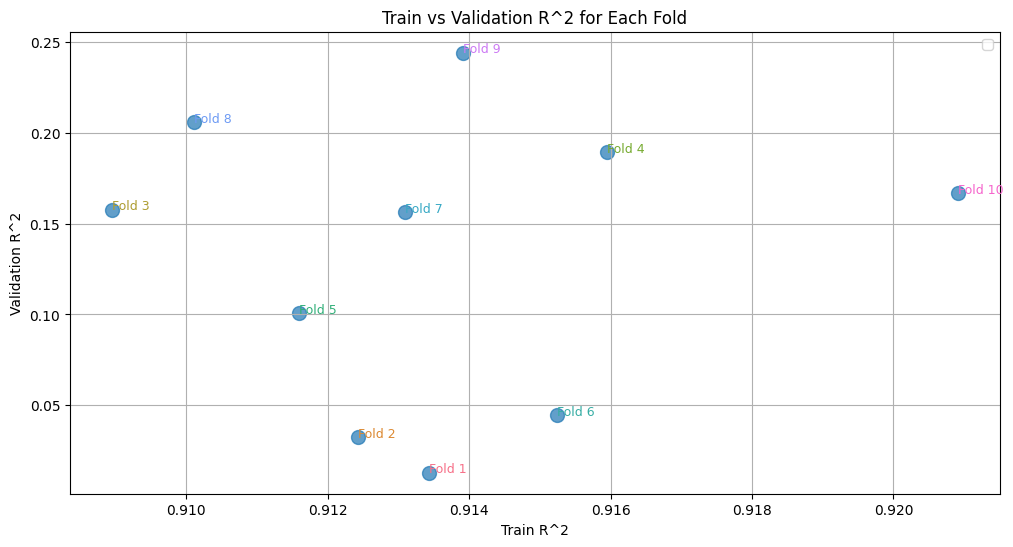

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\3569636973.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


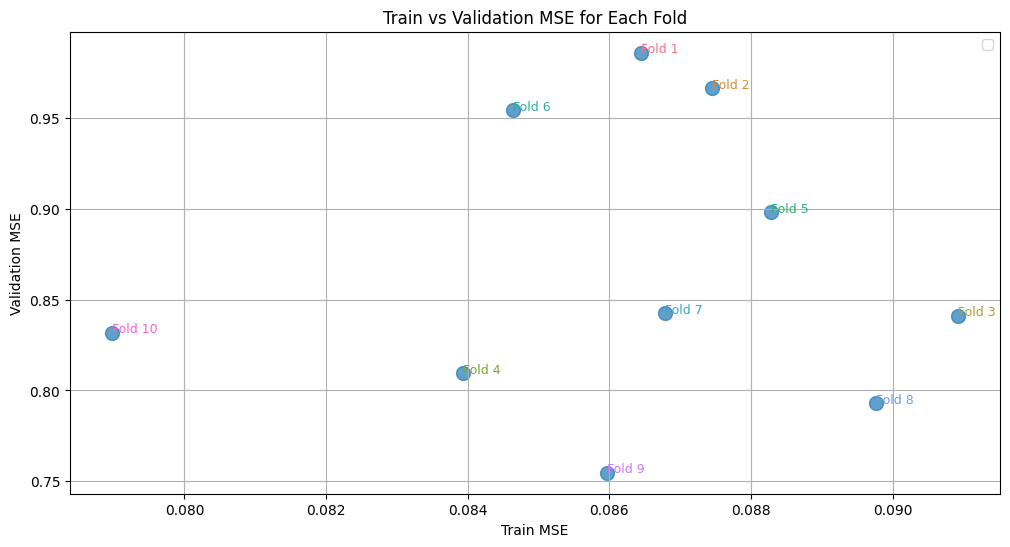

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\3569636973.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


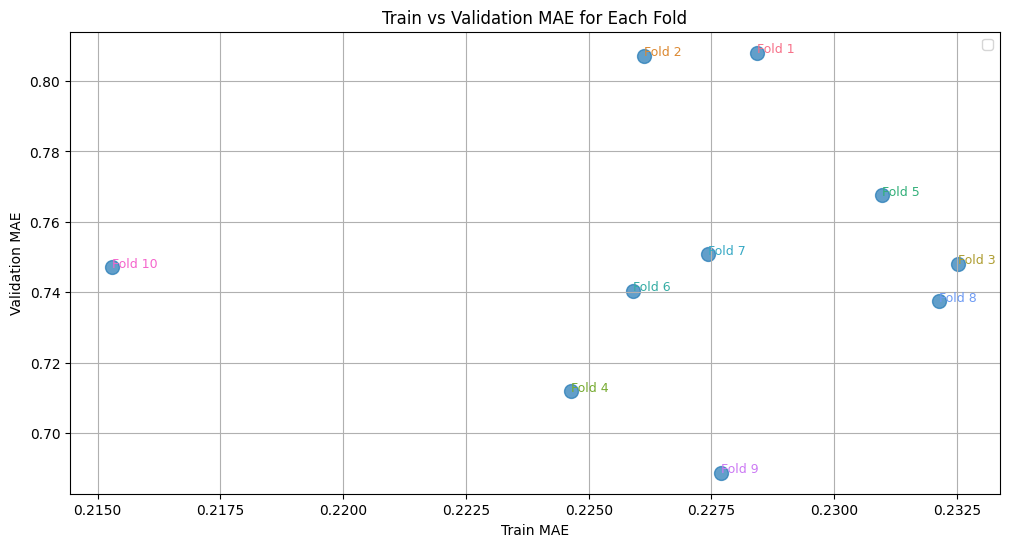

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\3569636973.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(features_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)


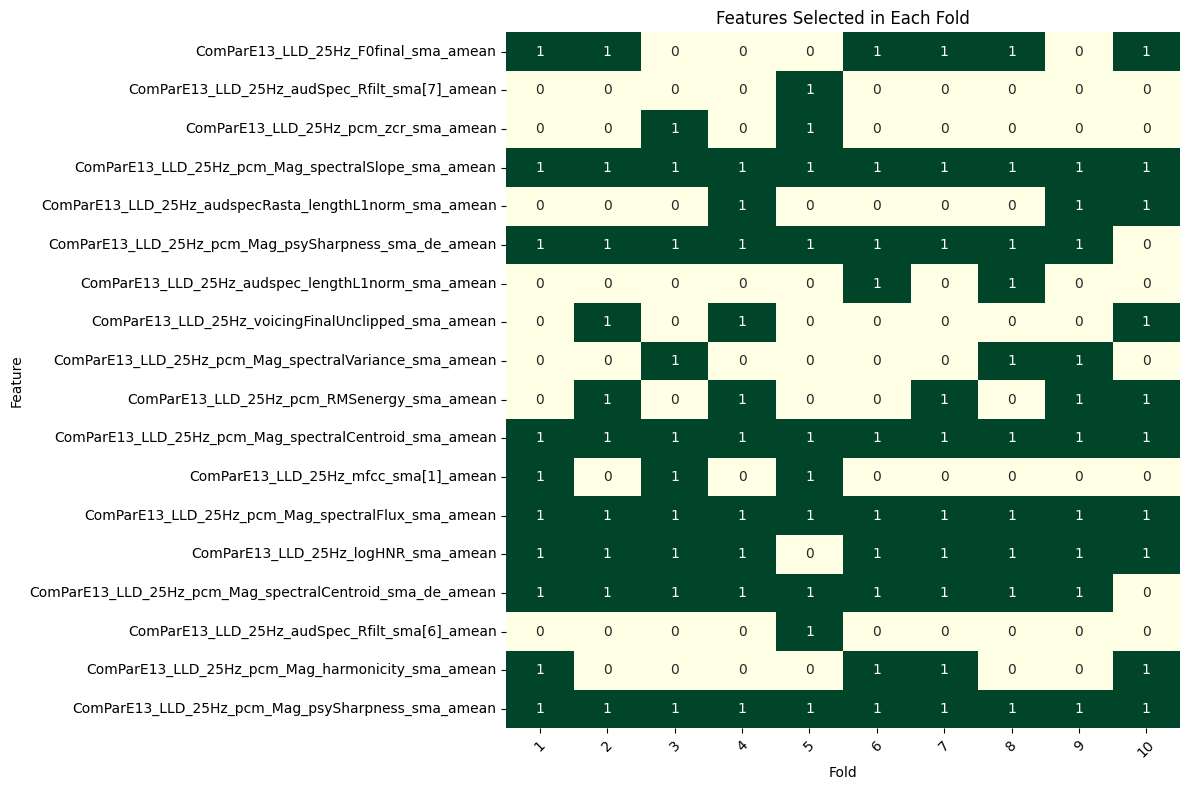

C:\Users\carme\AppData\Local\Temp\ipykernel_33964\3569636973.py:95: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(groups_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)


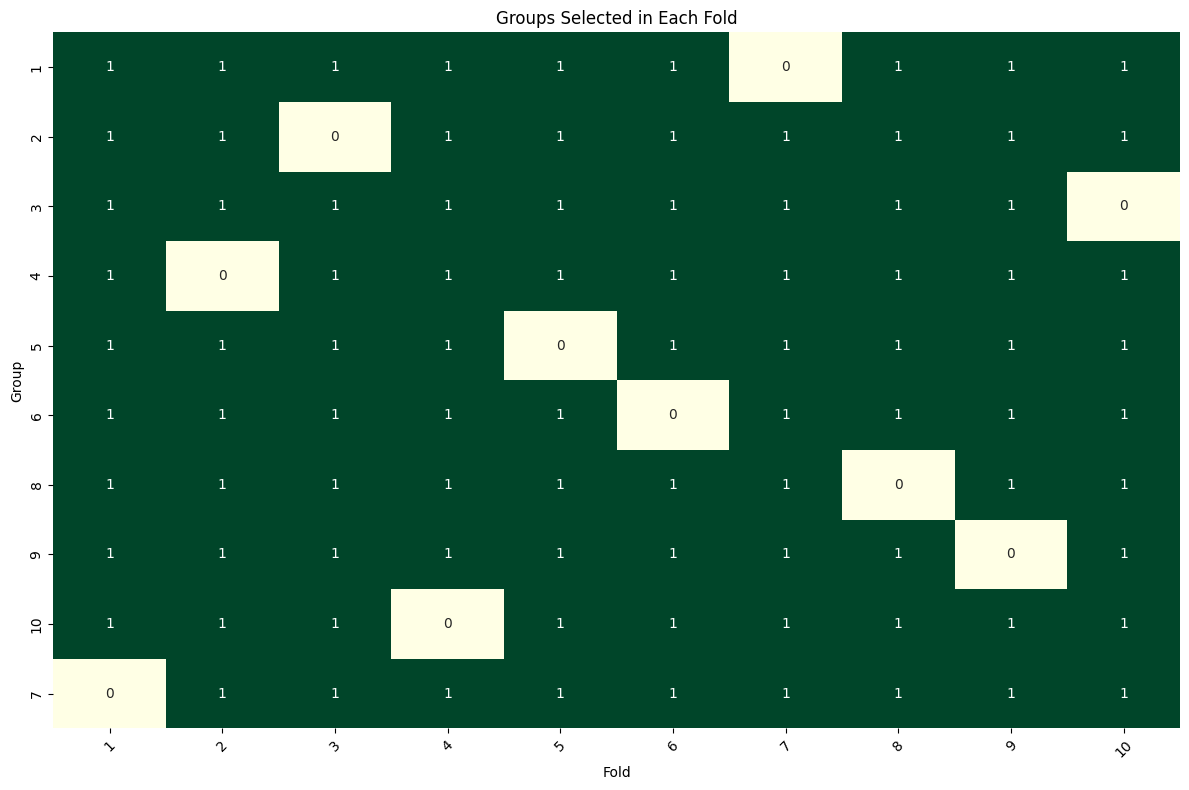

In [ ]:
# set different color per fold
colors = sns.color_palette("husl", NUMBER_OF_SPLITS)

plt.figure(figsize=(12, 6))
plt.scatter(results_df['Train R^2'], results_df['Val R^2'], alpha=0.7, s=100)
plt.title('Train vs Validation R^2 for Each Fold')
plt.xlabel('Train R^2')
plt.ylabel('Validation R^2')
for i, row in results_df.iterrows():
    plt.annotate(f"Fold {row['Fold']}", (row['Train R^2'], row['Val R^2']), fontsize=9, color=colors[i % NUMBER_OF_SPLITS])
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_df['Train MSE'], results_df['Val MSE'], alpha=0.7, s=100)
plt.title('Train vs Validation MSE for Each Fold')
plt.xlabel('Train MSE')
plt.ylabel('Validation MSE')
for i, row in results_df.iterrows():
    plt.annotate(f"Fold {row['Fold']}", (row['Train MSE'], row['Val MSE']), fontsize=9, color=colors[i % NUMBER_OF_SPLITS])
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_df['Train MAE'], results_df['Val MAE'], alpha=0.7, s=100)
plt.title('Train vs Validation MAE for Each Fold')
plt.xlabel('Train MAE')
plt.ylabel('Validation MAE')
for i, row in results_df.iterrows():
    plt.annotate(f"Fold {row['Fold']}", (row['Train MAE'], row['Val MAE']), fontsize=9, color=colors[i % NUMBER_OF_SPLITS])
plt.grid(True)
plt.legend()
plt.show()

# from results, a tabmel with features as rows and folds as columns. Each cell will have a yes if the feature was selected in that fold, and no otherwise
# get the superset of the selected features from the results

selected_features_set = set()
for fold in range(NUMBER_OF_SPLITS):
    selected_features_set.update(results_df.loc[fold, 'Selected Features'])
selected_features_set = list(selected_features_set)

features_selected_df = pd.DataFrame(index=(selected_features_set), columns=range(1, NUMBER_OF_SPLITS + 1))

# for each row in results_df, get the fold and the selected features, and fill the corresponding column in features_selected_df
for fold in range(NUMBER_OF_SPLITS):
    selected_features = results_df.loc[fold, 'Selected Features']
    for feature in selected_features_set:
        if feature in selected_features:
            features_selected_df.at[feature, fold + 1] = 'yes'
        else:
            features_selected_df.at[feature, fold + 1] = 'no'

features_selected_df.to_csv("features_selected.csv")

# draw features_selected_df as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(features_selected_df.applymap(lambda x: 1 if x == 'yes' else 0), cmap='YlGn', annot=True, fmt='d', cbar=False)
plt.title('Features Selected in Each Fold')
plt.xlabel('Fold')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# --- Optional: Final Model Training on full training data (X_train_full) ---
print("\n--- Training Final Model on Full Training Data ---")
final_estimator = LinearRegression()
final_n_features_to_select = int(np.mean([len(f) for f in selected_features_per_fold]))
print(f"Using {final_n_features_to_select} features for the final model (average from CV).")

final_rfe_selector = RFE(estimator=final_estimator, n_features_to_select=final_n_features_to_select, step=1)
final_rfe_selector.fit(X_train_full, y_train_full)
final_selected_features_mask = final_rfe_selector.support_
final_selected_features = X_train_full.columns[final_selected_features_mask].tolist()
print(f"Final selected features: {final_selected_features}")

X_train_final_selected = X_train_full[final_selected_features]
X_test_final_selected = X_test_final[final_selected_features]

final_model = LinearRegression()
final_model.fit(X_train_final_selected, y_train_full)

# Evaluate final model on the unseen test set
y_test_pred_final = final_model.predict(X_test_final_selected)
final_test_r2 = r2_score(y_test_final, y_test_pred_final)
final_test_mse = mean_squared_error(y_test_final, y_test_pred_final)
final_test_mae = mean_absolute_error(y_test_final, y_test_pred_final)

print(f"\n--- Final Model Performance on Unseen Test Set ---")
print(f"Test R^2: {final_test_r2:.4f}")
print(f"Test MSE: {final_test_mse:.4f}")
print(f"Test MAE: {final_test_mae:.4f}")

# Access coefficients of the FINAL model for interpretation
print(f"\n--- Coefficients of the Final Model ---")
for feature, coef in zip(final_selected_features, final_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {final_model.intercept_:.4f}")

count    733.000000
mean       0.177488
std        0.083128
min       -0.183600
25%        0.140400
50%        0.178867
75%        0.223200
max        0.399467
Name: median_arousal, dtype: float64


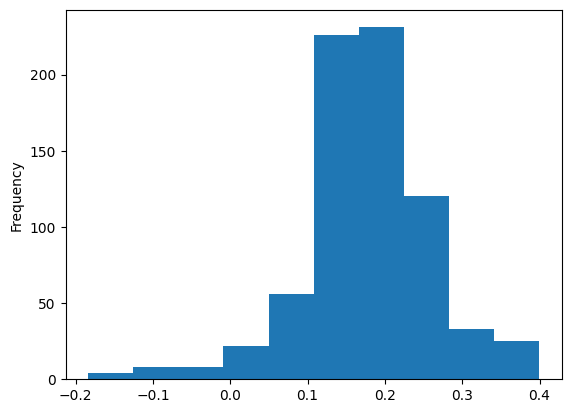

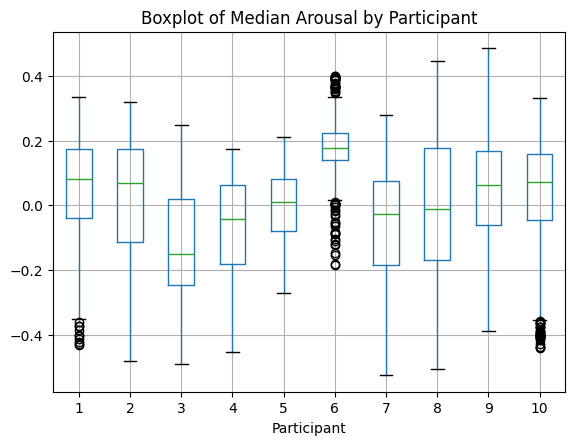

In [ ]:
desc = df_raw[df_raw['Participant'] == 6]['median_arousal'].describe()
print(desc)
df_raw[df_raw['Participant'] == 6]['median_arousal'].plot.hist()



## Step 1: Evaluate model performance using GroupKFold + RFE

This Step aims to assess the model's ability to generalize to new, unseen participants. To achieve this, we will implement the following methodologies:  

1. **Recursive Feature Elimination (RFE):** This technique will be utilized for selecting the most relevant features from our dataset, ensuring that the model focuses on the most informative variables, which can enhance its predictive accuracy.  

2. **Linear Regression:** We will employ linear regression as our primary estimator, leveraging its simplicity and interpretability to analyze the relationship between the selected features and the target outcome.  

3. **Group K-Fold Cross-Validation:** To minimize the data leakage risk and maintain the integrity of our evaluation, we will implement Group K-Fold Cross-Validation. This approach will allow us to partition our dataset to preserve participant groupings, thereby ensuring that the model is tested on entirely separate participants during each validation fold.  


This step aims to provide a clear and honest evaluation of your pipeline's effectiveness when applied to new, unseen participants. By using Recursive Feature Elimination (RFE) within each fold of the model evaluation process, we can prevent data leakage between the training and testing sets, thereby maintaining the integrity of the evaluation. It's important to note that we do not have a finalized model or a definitive set of features at this stage. Instead, you have performance metrics that reflect the current capabilities of our approach and lay the groundwork for future improvements.


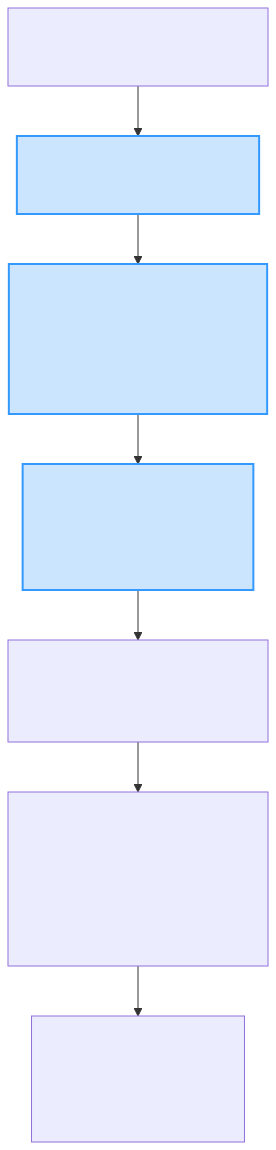

In [122]:
mm("""
flowchart TD
A["Start: Load full dataset (X, y, groups)"] --> B["Step 1: Evaluation Phase<br>GroupKFold CV with RFE"]
B --> B1[For each fold:<br>- Split by group<br>- Scale training features<br>- Fit RFE on training set\n- Train model<br>- Evaluate train and test MSE]
B1 --> C[Step 1 Output:<br>- Per-fold train/test MSE<br>- Average test MSE<br>- Check for overfitting]
C --> D[Step 2: Deployment Phase<br>Train final model on full dataset]
D --> D1[Actions:<br>- Scale all features<br>- Fit RFE on full data<br>- Select final features<br>- Train final regression model]
D1 --> E[Final Output:<br>- Model coefficients<br>- Selected features<br>- Ready for prediction]
style B fill:#cce5ff,stroke:#3399ff,stroke-width:2px
style B1 fill:#cce5ff,stroke:#3399ff,stroke-width:2px
style C fill:#cce5ff,stroke:#3399ff,stroke-width:2px
  
""")

In [123]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load dataset

# Define target and group
y = df_raw['median_arousal']
groups = df_raw['Participant']
X = df_raw.drop(columns=['Participant', 'median_arousal', 'median_valence'])

# Create pipeline: scaling + RFE + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=LinearRegression(), n_features_to_select=20)),
    ('regressor', LinearRegression())
])

# GroupKFold setup
gkf = GroupKFold(n_splits=5)

# Evaluate model using cross-validation
cv_scores = cross_val_score(
    pipeline, X, y,
    cv=gkf.split(X, y, groups),
    scoring='neg_mean_squared_error'
)

# Report results
print("MSE per fold:", -cv_scores)
print("Average MSE:", -np.mean(cv_scores))



MSE per fold: [0.04449543 0.03735343 0.02319945 0.03131738 0.01665993]
Average MSE: 0.030605125127201604


Fold 1:
  Train MSE: 0.0220
  Test  MSE: 0.0445
Fold 2:
  Train MSE: 0.0234
  Test  MSE: 0.0374
Fold 3:
  Train MSE: 0.0263
  Test  MSE: 0.0232
Fold 4:
  Train MSE: 0.0246
  Test  MSE: 0.0313
Fold 5:
  Train MSE: 0.0280
  Test  MSE: 0.0167


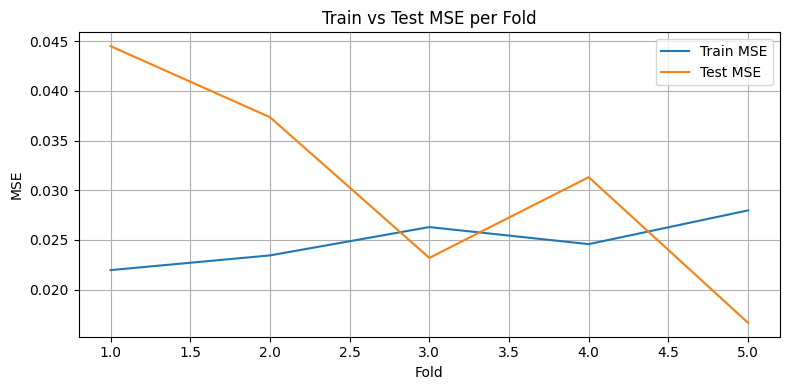

In [124]:
from sklearn.metrics import mean_squared_error

# Define model and selector again
estimator = LinearRegression()
rfe = RFE(estimator=estimator, n_features_to_select=20)

# GroupKFold setup
gkf = GroupKFold(n_splits=5)

train_mse = []
test_mse = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    # Split by fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit RFE on training data only
    rfe.fit(X_train_scaled, y_train)

    # Transform features
    X_train_sel = rfe.transform(X_train_scaled)
    X_test_sel = rfe.transform(X_test_scaled)

    # Fit model
    model = LinearRegression()
    model.fit(X_train_sel, y_train)

    # Predict and evaluate
    y_train_pred = model.predict(X_train_sel)
    y_test_pred = model.predict(X_test_sel)

    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

    print(f"Fold {fold + 1}:")
    print(f"  Train MSE: {train_mse[-1]:.4f}")
    print(f"  Test  MSE: {test_mse[-1]:.4f}")

# Optional: Plot the results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), train_mse, label='Train MSE')
plt.plot(range(1, 6), test_mse, label='Test MSE')
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("Train vs Test MSE per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The results indicate that our model is fairly consistent across participants, showing no significant performance outliers among the different folds. The model achieves its best performance (lowest error) in fold 5 and performs the worst in fold 1. However, the variation across folds is not extreme, which is a positive sign of stability.

## Step 2: Fit the Final Model on the Complete Dataset Using the Validated Pipeline  
 
To enhance our model's performance, we will first select a consistent set of features by applying Recursive Feature Elimination (RFE) on the entire dataset currently at our disposal. This process will help us to identify and retain only the most impactful features for our analysis. 

Once we have our selected features, we will proceed to fit a comprehensive Linear Regression model. This stage involves using the finalized feature set to train the model, ensuring that we capture the relationships within the data accurately.

In this phase, we are not assessing the performance of the model itself; rather, we are focused on enhancing its training for future applications. In the previous step, we have already calculated the generalization error using GroupKFold cross-validation in conjunction with Recursive Feature Elimination (RFE). This method is widely recognized in the field of machine learning as a standard procedure, ensuring that our approach is both reliable and effective.

In [125]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Reuse full X and y from Step 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit RFE on full dataset
final_rfe = RFE(estimator=LinearRegression(), n_features_to_select=20)
X_selected = final_rfe.fit_transform(X_scaled, y)

# Fit final linear regression model
final_model = LinearRegression()
final_model.fit(X_selected, y)

# Get selected feature names
selected_feature_names = X.columns[final_rfe.support_]

# Get coefficients and intercept
coefficients = final_model.coef_
intercept = final_model.intercept_

# Display results
print("Selected features:", selected_feature_names.tolist())
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Selected features: ['ComParE13_LLD_25Hz_F0final_sma_amean', 'ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean', 'ComParE13_LLD_25Hz_logHNR_sma_amean', 'ComParE13_LLD_25Hz_audspecRasta_lengthL1norm_sma_amean', 'ComParE13_LLD_25Hz_pcm_RMSenergy_sma_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[2]_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[3]_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[6]_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[7]_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[8]_amean', 'ComParE13_LLD_25Hz_audSpec_Rfilt_sma[10]_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralFlux_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralVariance_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralSlope_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_psySharpness_sma_amean', 'ComParE13_LLD_25Hz_pcm_Mag_harmonicity_sma_amean', 'ComParE13_LLD_25Hz_mfcc_sma[2]_amean', 'ComParE13_LLD_25Hz_pcm_Mag_spectralCentroid_sma_de_amean', 'ComParE13_LLD_25Hz_pc

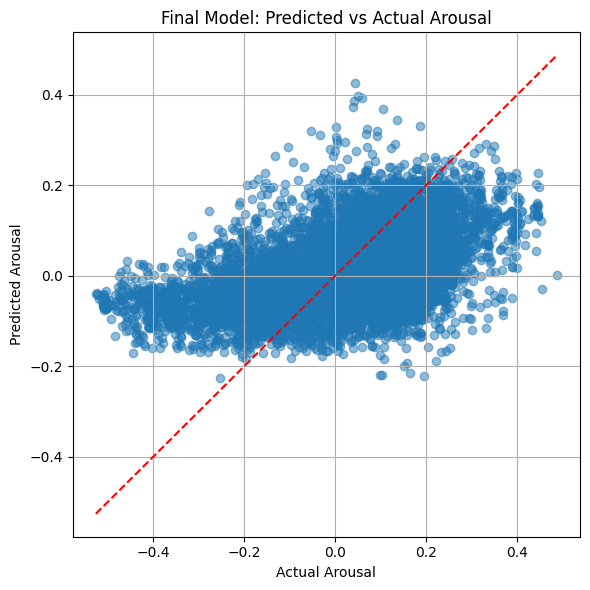

In [126]:
import matplotlib.pyplot as plt

# Step 3.1: Predict on full dataset
y_pred = final_model.predict(X_selected)

# Step 3.2: Visualize predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')  # identity line
plt.xlabel("Actual Arousal")
plt.ylabel("Predicted Arousal")
plt.title("Final Model: Predicted vs Actual Arousal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3.3: Save results if needed
df_results = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred
})
df_results.to_csv('final_arousal_predictions.csv', index=False)


A common approach in affect modelling is arousal/valence binarization. Towards this direction, a threshold value is defined and emotional states with arousal/valence values larger than or equal to that threshold are denoted as “high” arousal/valence, while emotional states with arousal/valence value lower than the threshold are denoted as “low” arousal/valence.

### Select and justify appropriate threshold values for binarizing both arousal and valence annotations (the threshold for binarizing arousal should not necessarily be equal to the threshold for binarizing valence).
### Implement a predictive model for each binarized response variable.
### Select appropriate metrics to evaluate the performance of the model in this scenario using the validation protocol you proposed in Task 1.

Emotions are inherently subjective, which can introduce bias during the annotation of affect datasets. One way to mitigate or reduce this subjectivity bias is to formulate affect modelling as a ranking problem. To achieve this, continuous arousal/valence labels are discretised into “high,” “medium,” and “low” categories.

### Select and justify appropriate threshold values for discretising (“high”, “neutral”,“low”) both arousal and valence annotations (the threshold for discretising arousalshould not necessarily be equal to the threshold for discretising valence).
### Implement a ranking predictive model for each response variable.
### Select appropriate metrics to evaluate the performance of the models in this scenario using the validation protocol you proposed in Task 1.

## Task 3
In this task, you will identify similar observations captured from the first participant (participant ID = 1). Complete the following steps:

### Create groups of similar observations from the first participant by proposing and implementing two suitable algorithms.
### Evaluate the clusters quality using appropriate metrics.
### Compare the algorithms you implemented and select the best one.
### Create visualisations for the clustering results.
### How would you assign a new observation from the first participant to an existing group?

## Task 4
Based on the results obtained from Task 3:

### Explain whether the clustering information could be used to build more accurate models for Task 2 and describe what you would do to build such models.